In [1]:
import numpy as np
import matplotlib.pyplot as plt
from codes import utils, model, interface, solvers, hf

In [2]:
hopp = np.kron(np.array([[0, 1], [0, 0]]), np.eye(2))
tb_model = {(0,): hopp + hopp.T.conj(), (1,): hopp, (-1,): hopp.T.conj()}


# define interaction
def intModel(U):
    model = {
        (0,): U * np.kron(np.ones((2, 2)), np.eye(2)),
    }
    return model

In [6]:
U0 = 1
nk = 100
filling = 2

hamiltonians_0 = utils.kgrid_hamiltonian(
    nk=nk, hk=utils.model2hk(tb_model=tb_model), dim=1
)

def groundstate(U):
    tb_mf = model.Model(tb_model=tb_model, int_model=intModel(U))
    tb_mf_k = interface.find_groundstate_ham(
        tb_mf,
        filling=filling,
        nk=nk,
        solver=solvers.rspace_solver,
        cost_function=solvers.real_space_cost,
        return_kspace=True,
    )
    vals, vecs = np.linalg.eigh(tb_mf_k)
    EF = utils.get_fermi_energy(vals, filling)
    densityMatrix = hf.density_matrix(vals, vecs, EF)

    return tb_mf_k, densityMatrix

@np.vectorize
def groundstateEnergy(U):
    _, densityMatrix = groundstate(U)
    Vk = utils.model2hk(tb_model=intModel(U))
    H_int = utils.kgrid_hamiltonian(nk=nk, hk=Vk, dim=1)
    mf = hf.compute_mf(densityMatrix, H_int)
    return hf.total_energy(mf + hamiltonians_0, densityMatrix)

tb_mf0, densityMatrix0 = groundstate(U0)
print(groundstateEnergy(U0))

@np.vectorize
def otherEnergy(U):
    # Total Energy with density matrix from the groundstate at U0
    Vk = utils.model2hk(tb_model=intModel(U))
    H_int = utils.kgrid_hamiltonian(nk=nk, hk=Vk, dim=1)
    mf = hf.compute_mf(densityMatrix0, H_int)
    return hf.total_energy(mf + hamiltonians_0, densityMatrix0)

-2.2252238082028337


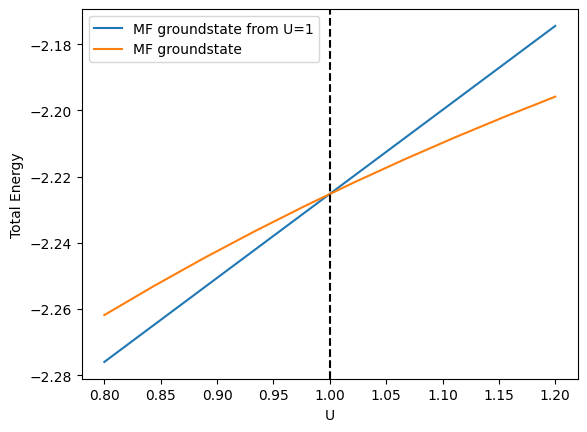

In [9]:
U_list = np.linspace(U0 - 0.2, U0 + 0.2, 10)
plt.plot(U_list, otherEnergy(U_list), label='MF groundstate from U=1')
plt.plot(U_list, groundstateEnergy(U_list), label='MF groundstate')
plt.axvline(x=1, c='k', ls='--')
plt.ylabel('Total Energy')
plt.xlabel('U')
plt.legend()